# Forecast Consumption

Forecasting using timeseries model the consumption of water, gas and electricity.



In [39]:
# from pathlib import Path
# import sys
# import pandas as pd

# sys.path.append(str(Path.cwd().parents[0]))
# from core.data_manager import read_data_csv_df


# # function to read the data
# def read_data_csv_df(directory: str, filename: str) -> pd.DataFrame:
#     path=Path.cwd().parents[0]
#     try:
#         df = pd.read_csv(path.joinpath(directory,filename))
#         return df
#     except FileNotFoundError:
#         print(f"File {filename} not found")
#         print("Please verify the file name and try again, and path")
#         exit()

# df = read_data_csv_df("data_storage", "resampled_data_D_gas.csv")


# "data_storage", "resampled_data_D_gas.csv"

# df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# df.columns
# print(df.columns)


## Preparing the data

In [40]:
# Import the necessary libraries
import sys
import pandas as pd
from os import path
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

# sys.path.append('../../')
# from core.settings import gas_monthly_df


In [41]:
# variables


path = Path.cwd().parents[0]



gas_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_gas.csv"))
# water_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_water.csv"))
# power_daily_df = pd.read_csv(path.joinpath("data_storage","resampled_data_D_power.csv"))

In [42]:
gas_daily_df.info()
# gas_monthly_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4779 entries, 0 to 4778
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       4779 non-null   object 
 1   id_meter   4779 non-null   float64
 2   gas_m3     4779 non-null   float64
 3   calc_cons  4777 non-null   float64
dtypes: float64(3), object(1)
memory usage: 149.5+ KB


In [43]:
print(gas_daily_df.head())
# Dealing with missing values
# # show NaN values rows
# gas_monthly_df[gas_monthly_df.isnull().any(axis=1)]

# # show duplicate rows
# gas_monthly_df[gas_monthly_df.duplicated()]

# # show rows for date 2014-09-04
# gas_monthly_df[gas_monthly_df['date'] == '2014-09-04']

# agregate by date
gas_daily_df = gas_daily_df.groupby('date').agg('sum').reset_index()


# fill row 0 NaN value with 0
gas_daily_df = gas_daily_df.fillna(0, inplace=False)

# # show duplicate dates rows
# gas_monthly_df[gas_monthly_df.duplicated(['date'])]

# # # drop duplicate dates rows
# # gas_monthly_df.drop_duplicates(subset=['date'], inplace=False)

gas_daily_df.info()

# # verify that there are not missing dates in the data
# gas_monthly_df['date'] = pd.to_datetime(gas_monthly_df['date'])
# gas_monthly_df['date'].diff().dt.days





         date  id_meter        gas_m3  calc_cons
0  2014-09-04       1.0  38911.506000        NaN
1  2014-09-05       1.0  38912.741875   1.235875
2  2014-09-06       1.0  38913.977750   1.235875
3  2014-09-07       1.0  38915.213625   1.235875
4  2014-09-08       1.0  38916.449500   1.235875
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       4750 non-null   object 
 1   id_meter   4750 non-null   float64
 2   gas_m3     4750 non-null   float64
 3   calc_cons  4750 non-null   float64
dtypes: float64(3), object(1)
memory usage: 148.6+ KB


In [44]:
# # drop columns not columns 1 to 3
# gas_daily_df = gas_daily_df.drop(gas_daily_df.columns[1:3], axis=1, inplace=False)

# gas_daily_df.info()


In [45]:
# convert date column to datetime
gas_daily_df['date'] = pd.to_datetime(gas_daily_df['date'])
# set date column as index
gas_daily_df.set_index('date', inplace=True)


In [46]:
gas_daily_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4750 entries, 2011-06-01 to 2024-06-01
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id_meter   4750 non-null   float64
 1   gas_m3     4750 non-null   float64
 2   calc_cons  4750 non-null   float64
dtypes: float64(3)
memory usage: 148.4 KB


## Prepare the model

In [47]:
# # subsample the data to hourly
# gas_hourly_df = gas_daily_df.resample('h').mean()


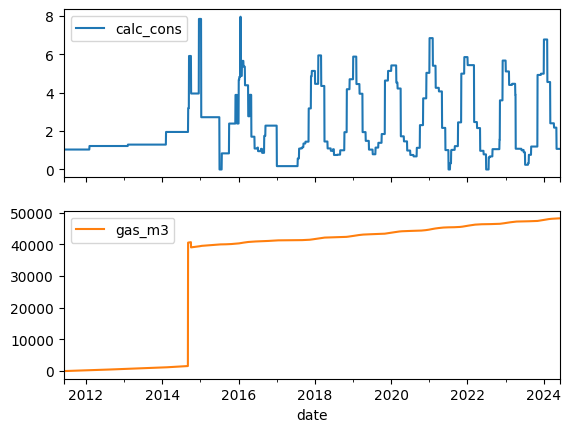

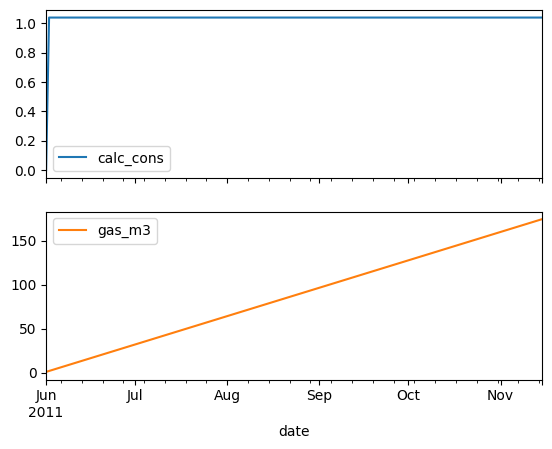

In [49]:
plot_cols = ["calc_cons","gas_m3"]
plot_features = gas_daily_df[plot_cols]
plot_features.index = gas_daily_df.index
_ = plot_features.plot(subplots=True)

plot_features = gas_daily_df[plot_cols][:168]
plot_features.index = gas_daily_df.index[:168]
_ = plot_features.plot(subplots=True)